In [1]:
from keras.optimizers import SGD, Adam
from keras.applications import *
from keras.callbacks import *
from keras.applications.resnet50 import ResNet50, preprocess_input

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Model
from keras import optimizers

import numpy as np
import shap
import keras.backend as K
import json
import split_folders
import urllib
import os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [ ]:
split_folders.ratio('../data/', output="output", seed=1337, ratio=(.8, .2))

In [2]:
target_size = 325

img_width = target_size
img_height = target_size
batch_size =30

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling (we do not want to modify the testing data)
test_datagen = ImageDataGenerator(rescale=1. / 255)


# The generator object. 
train_generator = train_datagen.flow_from_directory(
    'output/train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'output/val',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 11926 images belonging to 35 classes.
Found 3053 images belonging to 35 classes.


In [3]:
base_model = resnet50.ResNet50(include_top=False, weights='imagenet',
                       input_tensor=None, input_shape=(target_size,target_size,3), pooling=None)



Instructions for updating:
Colocations handled automatically by placer.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [4]:
TRAIN_DIR = "output/train"
TEST_DIR = "output/val"
HEIGHT = target_size
WIDTH = target_size
BATCH_SIZE = 30

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True,
      shear_range=0.2,
      zoom_range=0.2
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)

test_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input)

test_generator = train_datagen.flow_from_directory(TEST_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)

Found 11926 images belonging to 35 classes.
Found 3053 images belonging to 35 classes.


In [5]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

class_list = train_generator.class_indices
FC_LAYERS = [512]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
if not os.path.exists('checkpoints'):
        os.mkdir('checkpoints')

In [7]:
NUM_EPOCHS = 5
BATCH_SIZE = 30
num_train_images = 12000

adam = Adam(lr=0.00001) # was 0.00001
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

filepath="./checkpoints/" + "ResNet50" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

history = finetune_model.fit_generator(train_generator, epochs=NUM_EPOCHS, workers=8, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       shuffle=True, callbacks=callbacks_list, validation_data = test_generator,
                                      validation_steps=10, use_multiprocessing=True)

Instructions for updating:
Use tf.cast instead.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
 77/400 [====>.........................] - ETA: 1:31 - loss: 2.1019 - acc: 0.5662

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


 79/400 [====>.........................] - ETA: 1:30 - loss: 2.0581 - acc: 0.5751

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


 80/400 [=====>........................] - ETA: 1:29 - loss: 2.0844 - acc: 0.5704

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


 81/400 [=====>........................] - ETA: 1:28 - loss: 2.0603 - acc: 0.5753

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


 82/400 [=====>........................] - ETA: 1:27 - loss: 2.0801 - acc: 0.5695

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


 83/400 [=====>........................] - ETA: 1:26 - loss: 2.0874 - acc: 0.5671

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


 84/400 [=====>........................] - ETA: 1:25 - loss: 2.0798 - acc: 0.5683

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


 86/400 [=====>........................] - ETA: 1:24 - loss: 2.0509 - acc: 0.5748

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


399/400 [============================>.] - ETA: 0s - loss: 1.6109 - acc: 0.6197

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


400/400 [==============================] - 71s 177ms/step - loss: 1.6072 - acc: 0.6206 - val_loss: 2.1485 - val_acc: 0.4000


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')



Epoch 00001: saving model to ./checkpoints/ResNet50_model_weights.h5


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch 2/5
281/400 [====================>.........] - ETA: 18s - loss: 1.1627 - acc: 0.7031

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 5. Skipping tag 42036
  " Skipping tag %s" % (size, len(data), tag))


283/400 [====================>.........] - ETA: 17s - loss: 1.1642 - acc: 0.7021

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 5. Skipping tag 42036
  " Skipping tag %s" % (size, len(data), tag))


284/400 [====================>.........] - ETA: 17s - loss: 1.1621 - acc: 0.7027

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 5. Skipping tag 42036
  " Skipping tag %s" % (size, len(data), tag))


285/400 [====================>.........] - ETA: 17s - loss: 1.1598 - acc: 0.7033

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 5. Skipping tag 42036
  " Skipping tag %s" % (size, len(data), tag))


286/400 [====================>.........] - ETA: 17s - loss: 1.1570 - acc: 0.7040

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 5. Skipping tag 42036
  " Skipping tag %s" % (size, len(data), tag))


287/400 [====================>.........] - ETA: 17s - loss: 1.1536 - acc: 0.7049

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 5. Skipping tag 42036
  " Skipping tag %s" % (size, len(data), tag))


288/400 [====================>.........] - ETA: 17s - loss: 1.1621 - acc: 0.7034

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 5. Skipping tag 42036
  " Skipping tag %s" % (size, len(data), tag))


291/400 [====================>.........] - ETA: 16s - loss: 1.1665 - acc: 0.7014

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 5. Skipping tag 42036
  " Skipping tag %s" % (size, len(data), tag))


399/400 [============================>.] - ETA: 0s - loss: 1.1312 - acc: 0.7087

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


400/400 [==============================] - 62s 156ms/step - loss: 1.1326 - acc: 0.7082 - val_loss: 2.1793 - val_acc: 0.3933

Epoch 00002: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 3/5
400/400 [==============================] - 62s 154ms/step - loss: 0.8775 - acc: 0.7656 - val_loss: 1.5368 - val_acc: 0.4733

Epoch 00003: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 4/5
400/400 [==============================] - 62s 155ms/step - loss: 0.8040 - acc: 0.7892 - val_loss: 0.9584 - val_acc: 0.6133

Epoch 00004: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 5/5
 64/400 [===>..........................] - ETA: 49s - loss: 0.6442 - acc: 0.8307

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 70/400 [====>.........................] - ETA: 48s - loss: 0.6376 - acc: 0.8314

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 71/400 [====>.........................] - ETA: 48s - loss: 0.6384 - acc: 0.8310

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 73/400 [====>.........................] - ETA: 47s - loss: 0.6742 - acc: 0.8233

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 75/400 [====>.........................] - ETA: 47s - loss: 0.6603 - acc: 0.8271

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 77/400 [====>.........................] - ETA: 47s - loss: 0.6462 - acc: 0.8307

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 84/400 [=====>........................] - ETA: 46s - loss: 0.6647 - acc: 0.8258

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 91/400 [=====>........................] - ETA: 45s - loss: 0.6812 - acc: 0.8209

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


400/400 [==============================] - 63s 156ms/step - loss: 0.6183 - acc: 0.8363 - val_loss: 1.5944 - val_acc: 0.5800

Epoch 00005: saving model to ./checkpoints/ResNet50_model_weights.h5


In [ ]:
img = load_img('test-images/border-collie-test.jpg',target_size=(target_size,target_size) )
img = img_to_array(img)
img = img.reshape((1,) + img.shape)

pred = finetune_model.predict(img)
np.round(pred, decimals=3)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions

In [ ]:
img = load_img('test-images/corgi-test.jpg',target_size=(target_size,target_size) )
img = img_to_array(img)
img = img.reshape((1,) + img.shape)

pred = finetune_model.predict(img)
np.round(pred, decimals=3)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions

In [ ]:
img = load_img('test-images/husky-test.jpg',target_size=(target_size,target_size) )
img = img_to_array(img)
img = img.reshape((1,) + img.shape)

pred = finetune_model.predict(img)
np.round(pred, decimals=3)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions

In [ ]:
img = load_img('test-images/poodle-test.jpg',target_size=(target_size,target_size) )
img = img_to_array(img)
img = img.reshape((1,) + img.shape)

pred = finetune_model.predict(img)
np.round(pred, decimals=3)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions

In [8]:
img = load_img('test-images/vizsla-test.jpg',target_size=(target_size,target_size) )
img = img_to_array(img)
img = img.reshape((1,) + img.shape)

pred = finetune_model.predict(img)
print(np.round(pred, decimals=3))
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions

[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.
  0.    0.    0.    0.    0.    0.13  0.001 0.01  0.    0.    0.    0.006
  0.    0.    0.    0.001 0.    0.    0.    0.    0.013 0.835 0.   ]]


['weimaraner']

In [9]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions

['weimaraner']

In [21]:
custom_config=tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
custom_config.gpu_options.allocator_type = 'BFC'
custom_config.gpu_options.per_process_gpu_memory_fraction = 0.90

NameError: name 'tf' is not defined

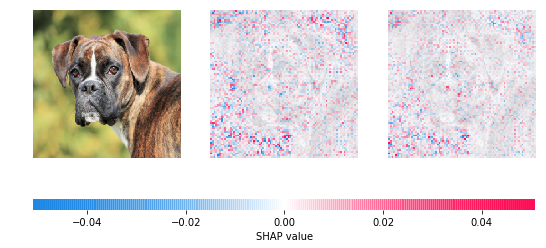

In [15]:
# load pre-trained model and choose two images to explain

model = finetune_model
# X,y = shap.datasets.imagenet50()
img = load_img('output/val/boxer/1485179194-boxer-dog-portrait.jpg',target_size=(target_size,target_size))
img = img_to_array(img)
img = img.reshape((1,) + img.shape)
to_explain = img
X = img

# # load the ImageNet class names
# url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
# fname = shap.datasets.cache(url)
# with open(fname) as f:
#     class_names = json.load(f)
class_names = labels

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

e = shap.GradientExplainer((model.layers[7].input, model.layers[-1].output), map2layer(preprocess_input(X.copy()), 7))
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
# index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
index_names = class_names.values

# plot the explanations
shap.image_plot(shap_values, to_explain, None)

In [13]:
class_names


{0: 'australian_shepherd',
 1: 'basset_hound',
 2: 'beagle',
 3: 'bernese_mountain_dog',
 4: 'border_collie',
 5: 'boston_terrier',
 6: 'boxer',
 7: 'brittany',
 8: 'bull_mastiff_',
 9: 'cane_corso',
 10: 'cavalier_king_charles_spaniel',
 11: 'chihuahua',
 12: 'cocker_spaniel',
 13: 'collie_',
 14: 'dachshund',
 15: 'english_springer_spaniel',
 16: 'german_shepherd',
 17: 'german_shorthaired_pointer',
 18: 'golden_retriever',
 19: 'great_dane',
 20: 'havanese',
 21: 'labrador_retriever_',
 22: 'maltese_',
 23: 'miniature_schnauzer_',
 24: 'newfoundland_',
 25: 'pembroke_welsh_corgi',
 26: 'poodle',
 27: 'pug',
 28: 'rottweiler',
 29: 'shetland_sheepdog',
 30: 'shih_tzu',
 31: 'siberian_husky',
 32: 'vizsla',
 33: 'weimaraner',
 34: 'yorkshire_terrier'}

In [ ]:
# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True) ## CHANGE INCLUDE TOP TO FALSE
X,y = shap.datasets.imagenet50()
to_explain = X[[6,7]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer((model.layers[7].input, model.layers[-1].output), map2layer(preprocess_input(X.copy()), 7))
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)